# Brief problem description 
Link to competition: https://dacon.io/competitions/official/235591/overview/ 

The primary aim of this contest is to predict the amount of rainfall given satellite information. Thus we are dealing with a regression problem. The provided train data is a condensed version of the GPM (global precipitation measurement) core satellite data provided by NASA. https://pmm.nasa.gov/gpm seems to contain more information on GPM. 

Also, the full train and test data can be downloaded from this public google drive link: https://drive.google.com/drive/folders/14EHxvp_Nc7iFE0CBuF6Bz6GxtFUOXLBL. An exaplanation of the dataset is provided in https://dacon.io/competitions/official/235591/talkboard/400589 slide 8, or in this video https://dacon.io/competitions/official/235591/talkboard/400598 starting in sections 7:50 and 15:00. 

Essentially, the GPM satellites provide (mainly) two information: one from a sensor called GMI (GPM Microwave Imager) and another from a sensor called DPR (Dual Frequency Precipitation Radar). Both of theses are sensors on the GPM satellites. **We want to predict results of the DPR given data from the GMI. So the microwave images are the features and the precipitation is the label (something we want to predict)**. The reason why we want to be able to predict results from the DPR sensor instead of actually getting observations from the DPR sensor is because it has narrow bandwidth and cannot predict the full extent of the data covered by the GMI. Watch this https://dacon.io/competitions/official/235591/talkboard/400598 starting 8:20 to get a clearer explanation. 

### A bit more about GPM (from my shallow research) 
The GPM program uses 9 satellites and each satellite contains microwave sensors. Apparently, the microwave reflected from the Earth reacts with the water molecules in the atmosphere and we get data by observing this phenomenon (or the **brightness** caused by the microwave interacting with water molecules in the atmosphere). See slide 3 from this link: https://dacon.io/competitions/official/235591/talkboard/400589    


In [2]:
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt

Let's first read in the train data 

In [5]:
train_dir = './train/' 
train_files = [train_dir + x for x in os.listdir(train_dir)]

In [35]:
print(len(train_files)) 
train_sample = np.load(train_files[15]) # just randomly took some sample 
print(train_sample.shape) 

76345
(40, 40, 15)


As we can see, there are 76345 training data and each data is of dimension 40x40x15. So there are 15 channels in total, where each channel is of dimension 40x40. Each channel represents the following information: brightness0,brightness1,..,brightness8,indicator type (지표타입), GMI Longitude (경도), GMI Latitude (위도),DPR Longitude (경도), DPR Latitude (위도), Precipitation (mm/h). The explanation of the data can be viewed here: https://dacon.io/competitions/official/235591/data/ under the data section. 

In [8]:
test_dir = './test/' 
test_files = [test_dir + x for x in os.listdir(test_dir)] 
test_sample = np.load(test_files[0]) 
print(test_sample.shape)

(40, 40, 14)


We see that one channel is missing for each of the test data (14 channels instead of 15) because we need to predict the precipitation for each of the test samples. 


Let's try to visualize the training data. From what I know, the first 9 channels (from 0 to 8) are the brightness detected by the GMI. Let's try to print these brightness channels as images. 

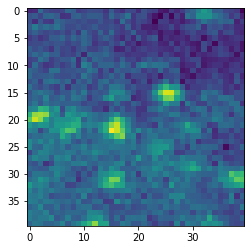

In [95]:
plt.imshow(train_sample[:,:,0]) 
plt.show()

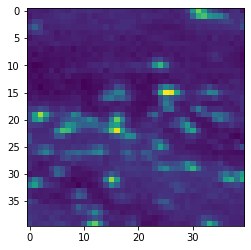

In [96]:
plt.imshow(train_sample[:,:,5]) 
plt.show()

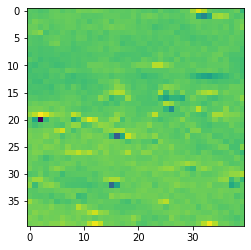

In [97]:
plt.imshow(train_sample[:,:,7]) 
plt.show()

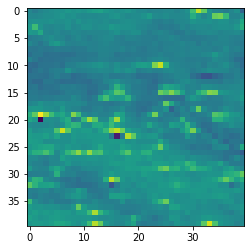

In [98]:
plt.imshow(train_sample[:,:,8]) 
plt.show()

For the brightness data, each pixel represents the temperature. Now, let's try and look at a sample precipitation image. 

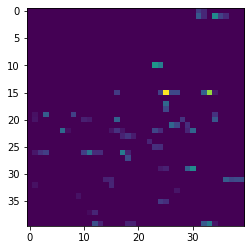

In [99]:
plt.imshow(train_sample[:,:,14])
plt.show()

Let's look at the precipitation data for another sample 

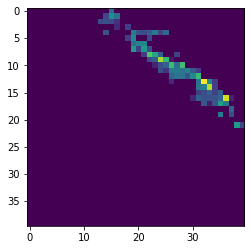

In [100]:
train_sample2 = np.load(train_files[100]) 
plt.imshow(train_sample2[:,:,14])
plt.show()

In [109]:
train_sample3 = np.load(train_files[120]) 
train_sample3[:,:,14]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [21.19002342, 21.19002342, 21.19002342, ...,  3.29143405,
         0.47390664,  0.28147343],
       [12.53909492, 12.53909492, 12.53909492, ...,  0.34647959,
         0.3707158 ,  0.27223057],
       [ 4.42280293,  4.42280293,  4.42280293, ...,  0.68790817,
         0.24807893,  0.21949118]])

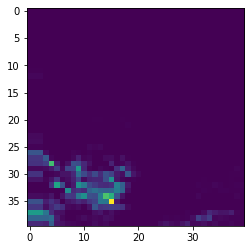

In [110]:
plt.imshow(train_sample3[:,:,14]) 
plt.show()

We see slightly brighter pixels in regions where precipitation values are 21.19,12.539,... etc. 

# Submission 
In order to submit for this competition, we have to make a prediction for the test data and save the prediction as csv and submit this single csv file. Below is the sample submission format 

In [113]:
df = pd.read_csv('./sample_submission.csv') 
df.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,029858_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,029858_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,029858_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,029858_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Because the precipitation data is 40x40, we need to predict the precipitation for each of the 1600 pixels and organize them in the format like above. The evaluation metric (scoring method) is described here: https://dacon.io/competitions/official/235591/overview/. They use the mean absolute error divided by the F1 Score.

Let's try a multiple linear regression for test submission (just because it is simple to implement - I am not claiming that there exists a linear relationship between the feature and the label). My plan is to flatten each of the 40x40 brightness data as well as the 40x40 precipitation data. So we will have 

$\hat Precipitation = \beta_0 + \beta_1 B_1 + ... + \beta_9 B_9$ 

Where $B_i$ is the ith brightness channel, $i = 1,..,9$. This is just an idea and I will try to implement this soon. 